# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Load-the-final-text-cleancat15-data" data-toc-modified-id="Load-the-final-text-cleancat15-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the final text cleancat15 data</a></div><div class="lev1 toc-item"><a href="#gm-vs-gc-Plots" data-toc-modified-id="gm-vs-gc-Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>gm vs gc Plots</a></div><div class="lev1 toc-item"><a href="#Plot-g00-vs-g20" data-toc-modified-id="Plot-g00-vs-g20-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot g00 vs g20</a></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Contd. Astrophysics</a>
    
    Date: Jan 10, 2020
</div>

# Introduction
Date: Dec 10, 2019 Mon

**Update**  
1. Looked at gm0 vs gc0 (and gm1 vs gc1) 45 degree line and removed outliers.
2. Find the weights for g_sq for given magnitude bins using smooth fitting curve.


**Usual Filtering**  
```python
df = df.query('calib_psfCandidate == 0.0')
df = df.query('deblend_nChild == 0.0')
df['ellip'] = np.hypot( df['ext_shapeHSM_HsmShapeRegauss_e1'] ,
                        df['ext_shapeHSM_HsmShapeRegauss_e2'] )
df = df.query('ellip < 2.0') # it was 1.5 before

#select only few columns after filtering:
cols_select = ['base_SdssCentroid_x', 'base_SdssCentroid_y',
                'base_SdssCentroid_xSigma','base_SdssCentroid_ySigma',
                'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                'base_SdssShape_flux']
df = df[cols_select]        

# drop all nans
df = df.dropna()

# additional columns
df['radius'] =  df.eval(""" ( (ext_shapeHSM_HsmSourceMoments_xx *  ext_shapeHSM_HsmSourceMoments_yy) \
                                          -  (ext_shapeHSM_HsmSourceMoments_xy**2 ) )**0.25 """)
```

**Shape filtering**  
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb
```python
df = df.query('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3')
df = df.query('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')
df = df.query('ext_shapeHSM_HsmShapeRegauss_flag== 0.0')
```

**Filter strongly lensed objects**  
- Take the objects with centroids >154 pixels (remove strong lens objects).
```python
# exclude strong lens objects <=154 distance
# The shape of lsst.fits file is 3998,3998 and center is 1699,1699.
df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
df = df[df.distance > 154]
```

**Imcat script**  
```bash

# create new columns and cleaning (four files)
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9T}".txt  |  lc +all 'mag = %flux log10 -2.5 *'  |  cleancat 15  |  lc +all -r 'mag' > "${M9C}".cat


# merge 4 catalogs
mergecats 5 "${MC}".cat "${M9C}".cat "${LC}".cat "${L9C}".cat > ${catalogs}/merge.cat &&
            
            
lc -b +all 
'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector'
'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 
'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector'   
'gmd = %g[0][0] %g[1][0] - 2 / %g[0][1] %g[1][1] - 2 / 2 vector' 
'gcd = %g[2][0] %g[3][0] - 2 / %g[2][1] %g[3][1] - 2 / 2 vector' 
< ${catalogs}/merge.cat > ${final}/final_${i}.cat
```
**Notes**  

final_text.txt is created by imcat program after merging four lsst files (m,m9,l,l9) after cleaning.

# Imports

In [1]:
import json, os,sys
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import plotly
import ipywidgets

pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

print([(x.__name__, x.__version__) for x in [np,pd,sns,plotly,ipywidgets]])

[('numpy', '1.17.4'), ('pandas', '0.24.2'), ('seaborn', '0.9.0'), ('plotly', '4.1.1'), ('ipywidgets', '6.0.0')]


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Load the final text cleancat15 data

```
g_sq = g00 g00 + g10 g10
gmd_sq = gmd0**2 + gmd1**2

```

In [3]:
!head -2 ../data/cleancat/final_text_cleancat15.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]
               0              0              0              0           5301           5314           5231           5117       88.17075      1847.1934         0.0196         0.0249         0.0227         0.0216           0.02         0.0256       

In [4]:
names = "fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]"
print(names)

fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]


In [5]:
names = ['fN[0][0]','fN[1][0]','fN[2][0]','fN[3][0]',
 'id[0][0]','id[1][0]','id[2][0]','id[3][0]',
 'x[0]','x[1]',
 'errx[0][0]','errx[0][1]','errx[1][0]','errx[1][1]','errx[2][0]',
 'errx[2][1]','errx[3][0]','errx[3][1]',
 'g[0][0]','g[0][1]','g[1][0]','g[1][1]','g[2][0]','g[2][1]','g[3][0]','g[3][1]',
 'ellip[0][0]','ellip[1][0]','ellip[2][0]','ellip[3][0]',
 'flux[0][0]','flux[1][0]','flux[2][0]','flux[3][0]',
 'radius[0][0]','radius[1][0]','radius[2][0]','radius[3][0]',
 'mag[0][0]','mag[1][0]','mag[2][0]','mag[3][0]',
 'gm[0]','gm[1]','gc[0]', 'gc[1]',
 'gmd[0]','gmd[1]','gcd[0]','gcd[1]']

In [6]:
file_path = f'../data/cleancat/final_text_cleancat15_100_150.txt'


def read_data(ifile):
    df = pd.read_csv(ifile,comment='#',engine='python',sep=r'\s\s+',
                     header=None,names=names)

    print(df.shape)

    # new columns
    # df['g_sq'] = df['g[0][0]'] **2 + df['g[1][0]']**2 # only for imcat 00 and 10
    # df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

    df['g_sq'] = df['g[0][0]'] **2 + df['g[0][1]']**2
    df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

    df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
    df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2

    df['mag_mono'] = (df['mag[0][0]'] + df['mag[1][0]'] ) / 2
    df['mag_chro'] = (df['mag[2][0]'] + df['mag[3][0]'] ) / 2
    
    return df


df = read_data(file_path)
df.head()

(27588, 50)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq,mag_mono,mag_chro
0,600,600,600,600,2839,2943,3401,3461,609.86253,450.70233,0.0096,0.0062,0.0057,0.0089,0.0088,0.0064,0.0056,0.0088,0.7432,-0.4243,-1.0663,0.4666,1.0475,-0.5707,-1.0218,0.4100,0.855790,1.163921,1.192877,1.100988,104627.430,102556.610,105105.630,104086.890,4.160584,4.012452,4.175768,4.050166,-12.549114,-12.527409,-12.554065,-12.543490,-0.16155,0.02115,0.01285,-0.08035,0.90475,-0.44545,1.03465,-0.49035,0.732377,1.016998,0.026546,0.006621,-12.538262,-12.548777
1,600,600,600,600,3536,3707,4230,4358,1321.84420,972.77863,0.0230,0.0461,0.0390,0.0207,0.0242,0.0415,0.0400,0.0212,-0.8642,-0.7978,0.9761,0.3934,-0.7444,-0.6528,0.8634,0.3916,1.176149,1.052395,0.990091,0.948056,38713.924,39559.363,39784.554,39195.822,5.126723,5.166262,5.197797,5.140643,-11.469668,-11.493123,-11.499286,-11.483099,0.05595,-0.20220,0.05950,-0.13060,-0.92015,-0.59560,-0.80390,-0.52220,1.383326,1.201415,0.044015,0.020597,-11.481395,-11.491193
2,600,600,600,600,2934,369,434,438,683.95075,524.64325,0.0073,0.0087,0.0071,0.0093,0.0071,0.0092,0.0069,0.0091,-0.4821,0.8435,-0.4429,0.9752,-0.3623,0.9354,-0.4656,0.8841,0.971552,1.071063,1.003112,0.999208,104305.460,103449.710,103592.050,103224.210,4.289903,4.202182,4.200716,4.169439,-12.545768,-12.536823,-12.538316,-12.534454,-0.46250,0.90935,-0.41395,0.90975,-0.01960,-0.06585,0.05165,0.02565,0.943913,0.004720,1.040824,0.999000,-12.541296,-12.536385
3,600,600,600,600,3895,4122,4611,4834,1550.88570,1473.80690,0.0634,0.0492,0.0990,0.0846,0.0898,0.0745,0.0929,0.0767,0.6175,-0.6139,0.5953,-0.3386,0.5278,-0.2861,0.4572,-0.1718,0.870735,0.684859,0.600355,0.488413,18641.755,18950.119,19675.394,20064.099,4.694274,4.960470,4.864858,5.083886,-10.676217,-10.694030,-10.734809,-10.756049,0.60640,-0.47625,0.49250,-0.22895,0.01110,-0.13765,0.03530,-0.05715,0.758179,0.019071,0.594535,0.294974,-10.685123,-10.745429
4,600,600,600,600,5575,5993,6717,6986,1441.77120,3082.27420,0.0516,0.0337,0.0249,0.0213,0.0315,0.0376,0.0236,0.0213,-0.4181,0.3506,0.7038,1.2643,-0.0972,0.8146,0.4156,0.8746,0.545645,1.446993,0.820379,0.968323,35673.751,35481.033,34435.355,35453.303,4.262026,4.145978,4.128826,4.151369,-11.380872,-11.374991,-11.342511,-11.374142,0.14285,0.80745,0.15920,0.84460,-0.56095,-0.45685,-0.25640,-0.03000,0.297728,0.523377,0.672382,0.738694,-11.377931,-11.358327


# gm vs gc Plots

In [7]:
def plot_gm_gc(df,start,end):
    fig,ax = plt.subplots(1,2,figsize=(16,8))
    df.plot.scatter(x='gm[0]',y='gc[0]', ax=ax[0])
    df.plot.scatter(x='gm[1]',y='gc[1]', ax=ax[1])

    ax[0].set_xlim(-2.0,2.0)
    ax[0].set_ylim(-2.0,2.0)

    ax[1].set_xlim(-2.0,2.0)
    ax[1].set_ylim(-2.0,2.0)

    # 45 degree line
    n=2.0
    ax[0].plot([-n,n],[-n,n],'r--')
    ax[1].plot([-n,n],[-n,n],'r--')

    plt.suptitle(f'gm vs gc plot from {start} to {end}',weight='bold',fontsize=24);

(56861, 50)


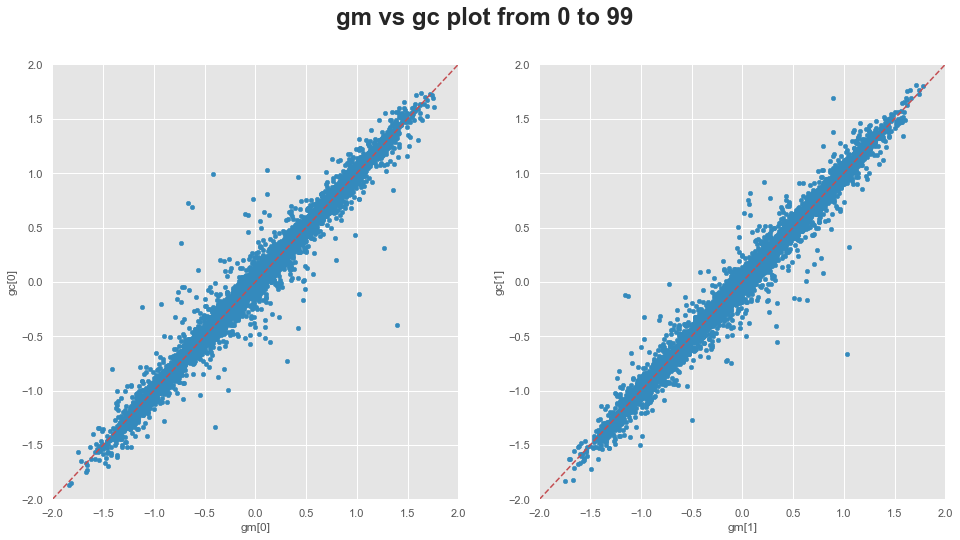

In [8]:
start = 0
end = 99
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_gm_gc(df,start,end)

(27588, 50)


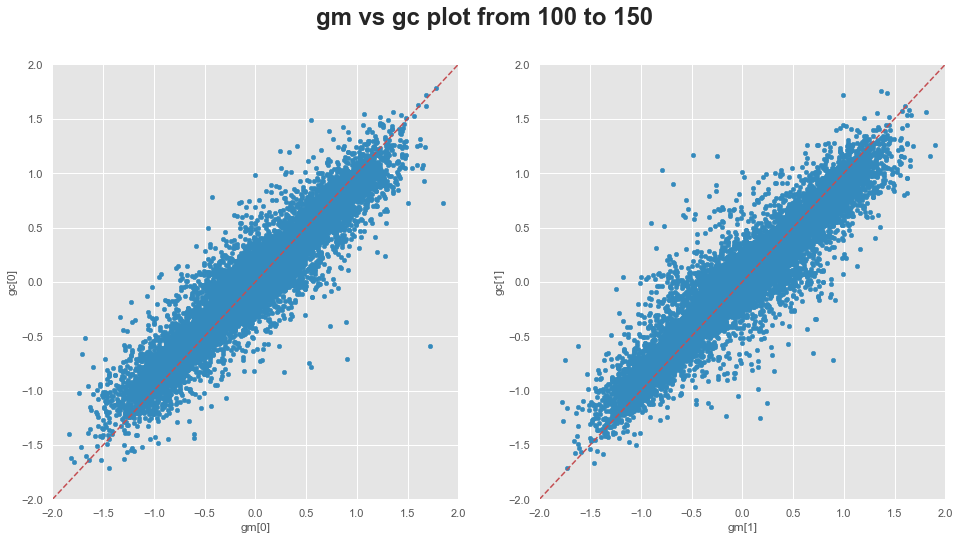

In [9]:
start = 100
end = 150


file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)
plot_gm_gc(df,start,end)

(25608, 50)


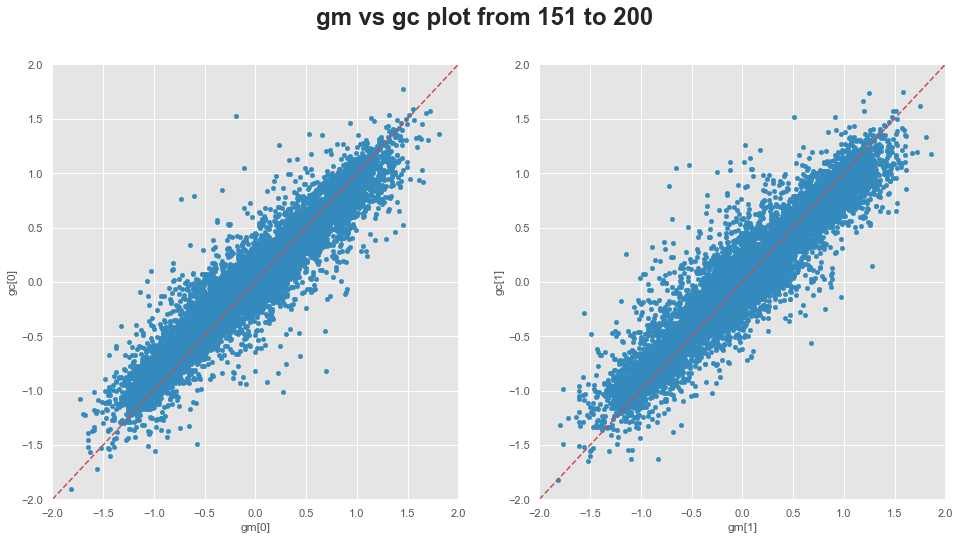

In [10]:
start = 151
end = 200

file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)
plot_gm_gc(df,start,end)

(26023, 50)


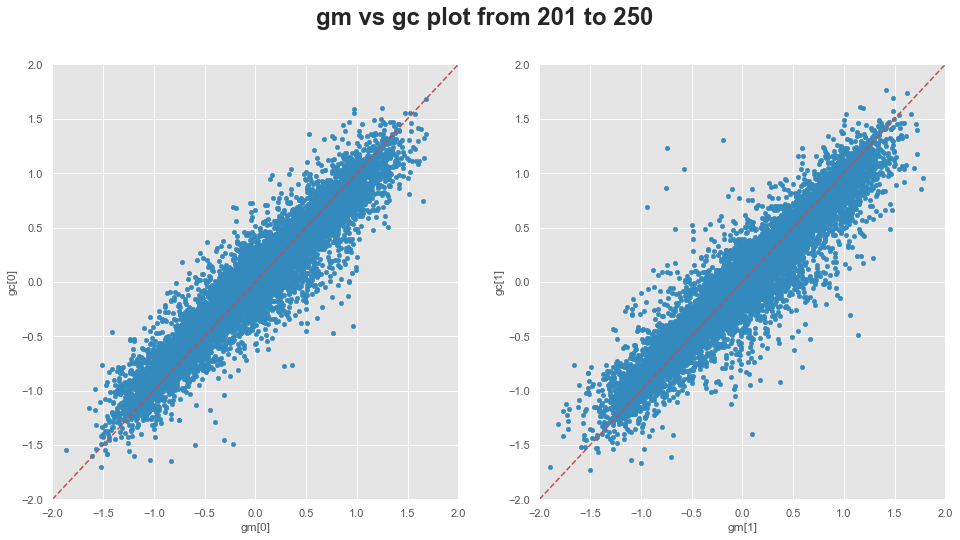

In [11]:
start = 201
end = 250


file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)
plot_gm_gc(df,start,end)

(25314, 50)


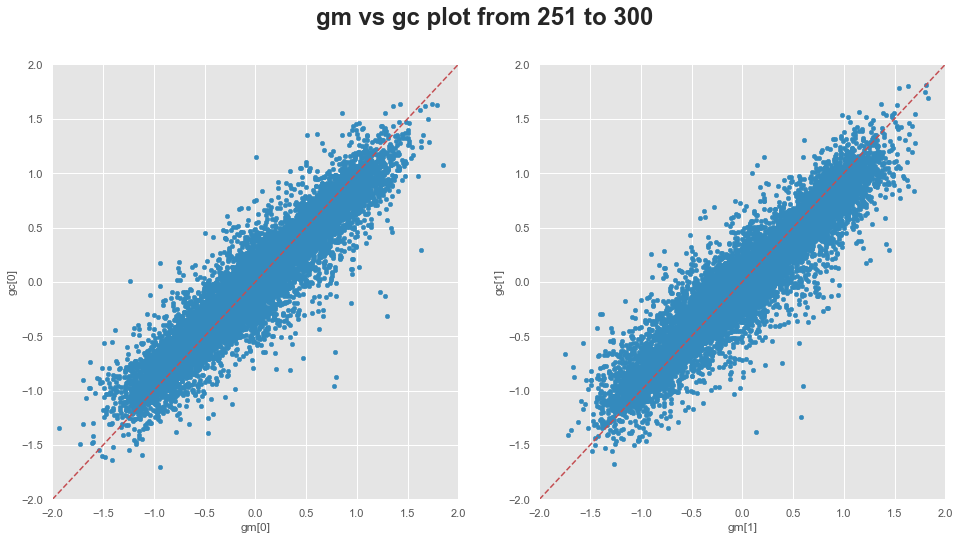

In [12]:
start = 251
end = 300


file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)
plot_gm_gc(df,start,end)

(15767, 50)


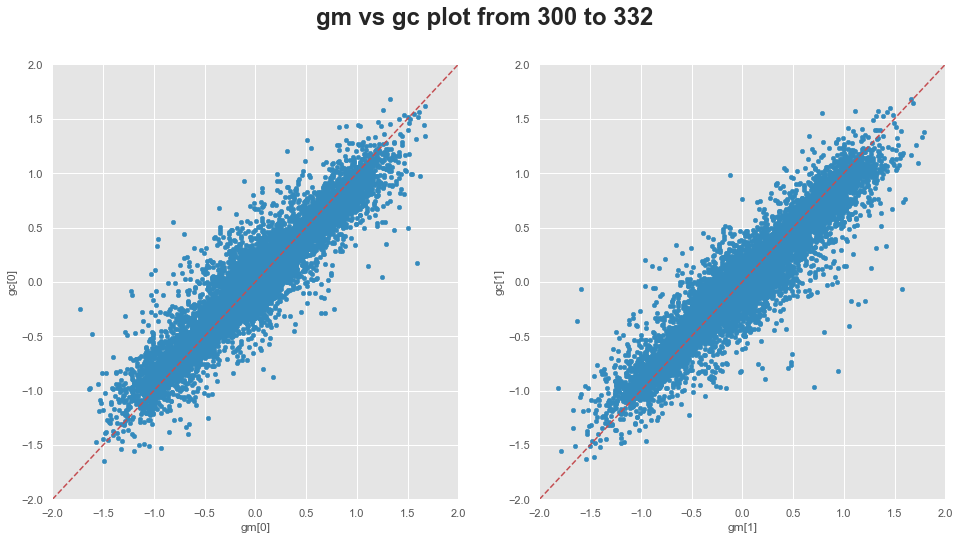

In [13]:
start = 300
end = 332


file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)
plot_gm_gc(df,start,end)

# Plot g00 vs g20

In [14]:
df.head(2).T

,0,1
fN[0][0],300.000000,300.000000
fN[1][0],300.000000,300.000000
fN[2][0],300.000000,300.000000
fN[3][0],300.000000,300.000000
id[0][0],6505.000000,6469.000000
id[1][0],6409.000000,6382.000000
id[2][0],6594.000000,6559.000000
id[3][0],6711.000000,6687.000000
x[0],2503.974800,585.088780
x[1],3192.773000,3144.083500


In [15]:
def plot_g00_20(df,start,end):
    fig,ax = plt.subplots(2,2,figsize=(16,12))
    
    df.plot.scatter(x='gm[0]',y='gc[0]', ax=ax[0][0])
    df.plot.scatter(x='gm[1]',y='gc[1]', ax=ax[0][1])
    
    df.plot.scatter(x='g[0][0]',y='g[2][0]', ax=ax[1][0])
    df.plot.scatter(x='g[0][1]',y='g[1][1]', ax=ax[1][1])

    ax[0][0].set_xlim(-2.0,2.0)
    ax[0][1].set_ylim(-2.0,2.0)

    ax[1][0].set_xlim(-2.0,2.0)
    ax[1][1].set_ylim(-2.0,2.0)

    # 45 degree line
    n=2.0
    #              x1,x2  y1,y2
    ax[0][0].plot([-n,n],[-n,n],'r--')
    ax[0][1].plot([-n,n],[-n,n],'r--')
    ax[1][0].plot([-n,n],[-n,n],'r--')
    ax[1][1].plot([-n,n],[-n,n],'r--')
    ax[1][1].plot([-n,n],[n,-n],'r--')

    plt.suptitle(f'gm vs gc plot from {start} to {end}',weight='bold',fontsize=24);

(56861, 50)


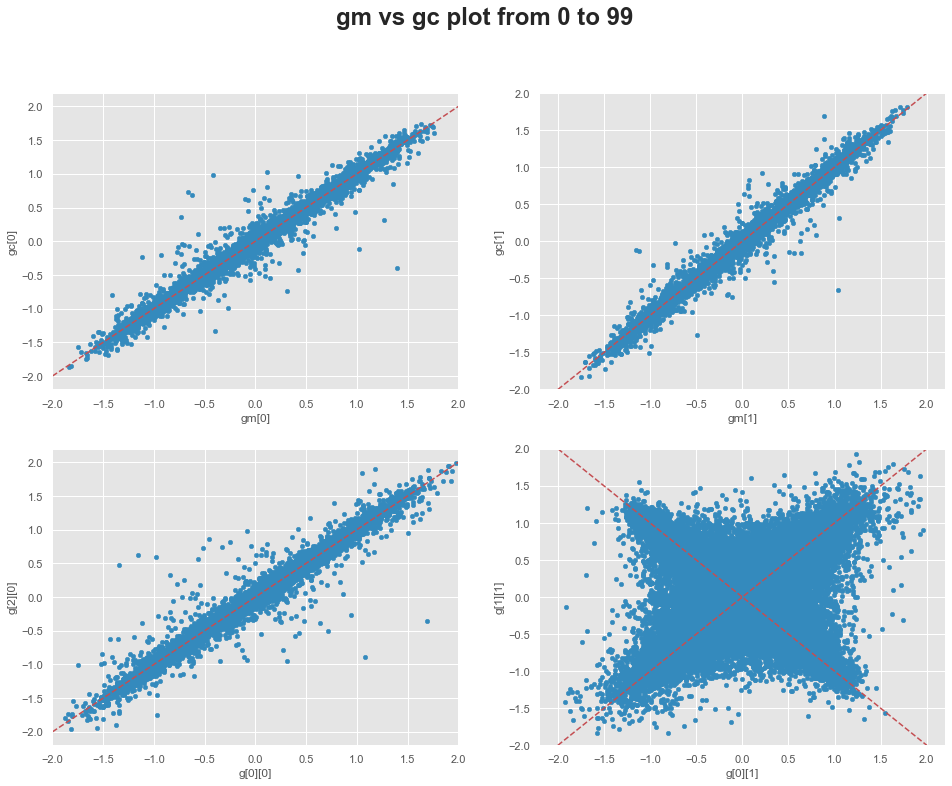

In [16]:
start = 0
end = 99
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)

(27588, 50)


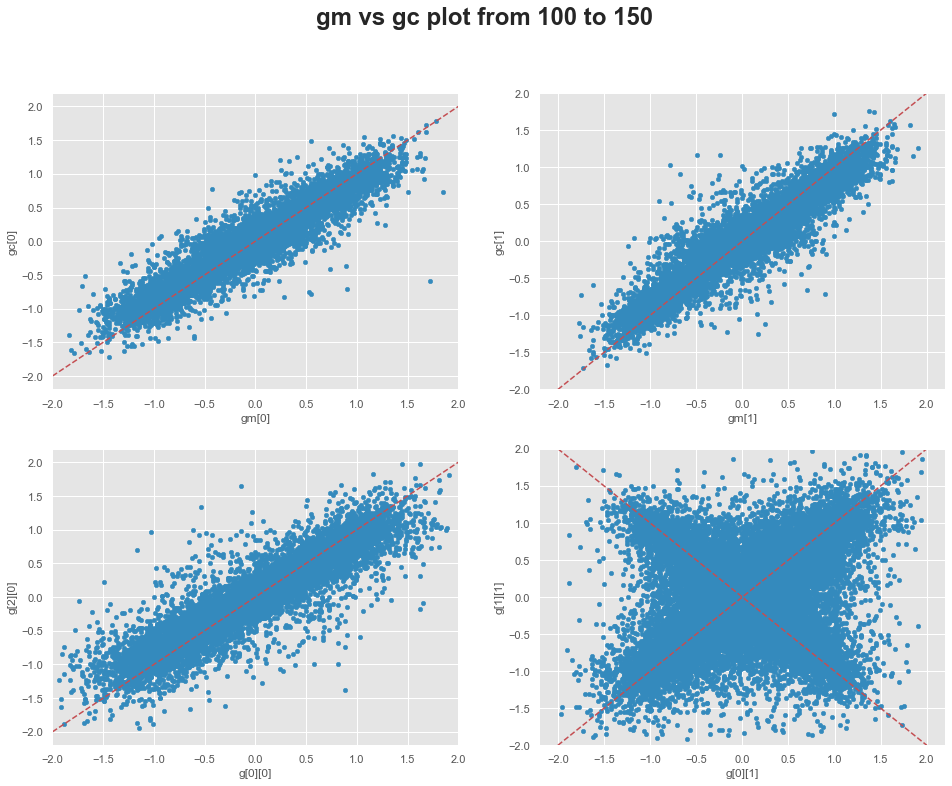

In [17]:
start = 100
end = 150
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)

(25608, 50)


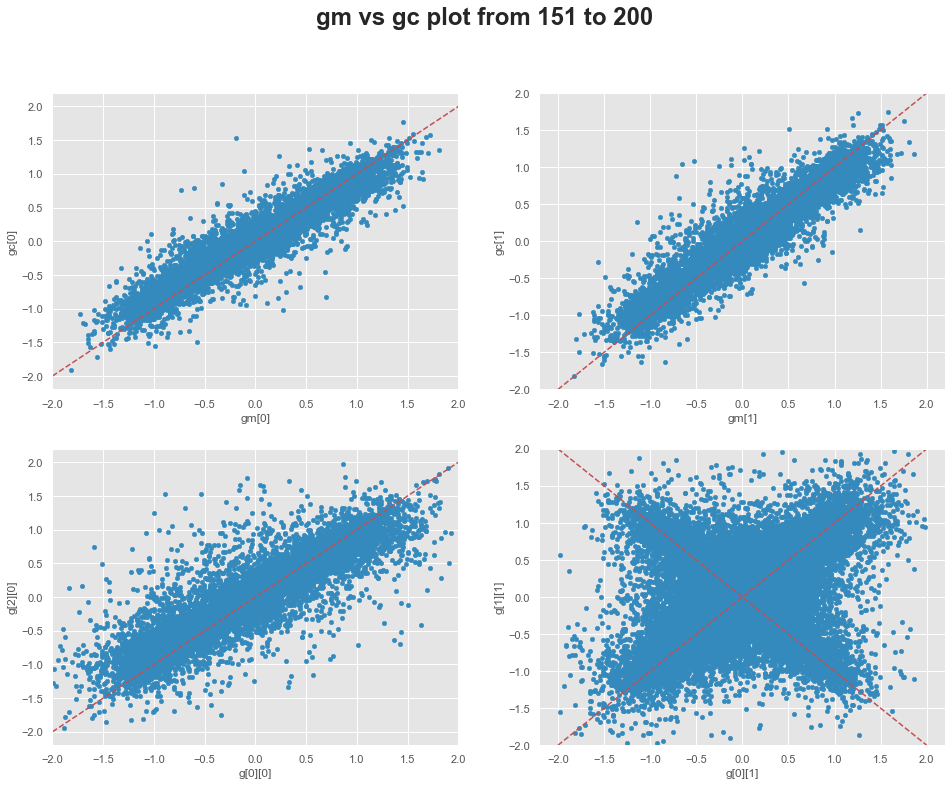

In [18]:
start = 151
end = 200
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)

(26023, 50)


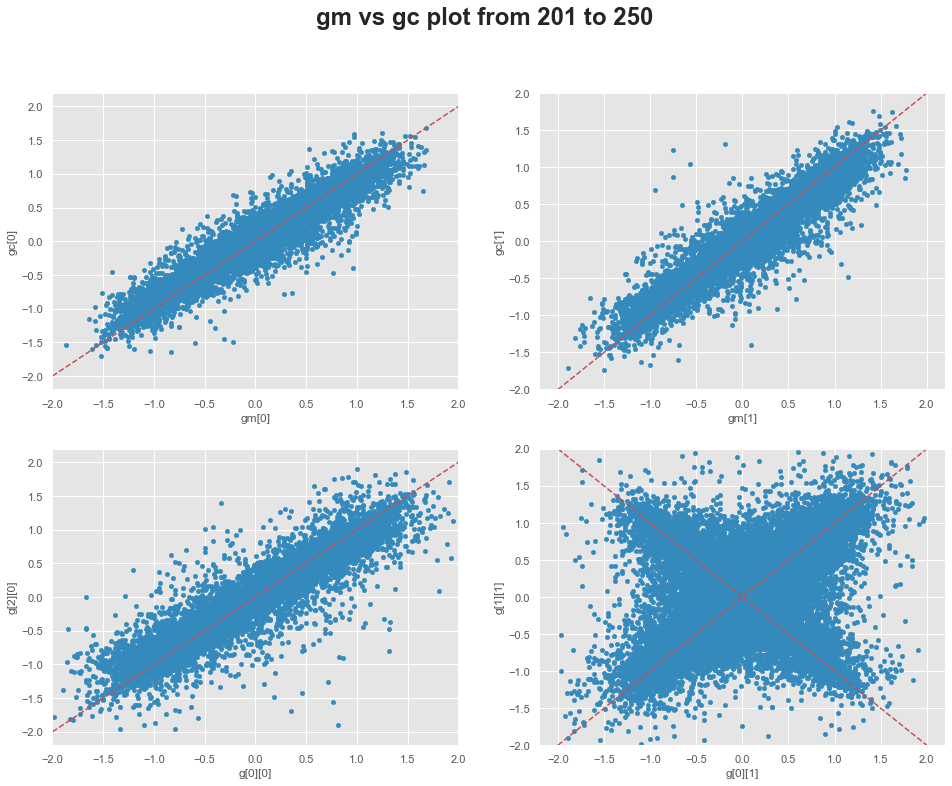

In [19]:
start = 201
end = 250
file_path = f'../data/cleancat/final_text_cleancat15_{start:03d}_{end:03d}.txt'
df = read_data(file_path)

plot_g00_20(df,start,end)